In [1]:
import torch
import os
from vit4elm.datasets import IsingData
from vit4elm.trainer import ClassificationTrainer
from torchvision.models import vit_b_32 # Use torchvision models or any torch.nn.Module
from torch.nn import CrossEntropyLoss # any nn.Module works as a loss
from torch.optim import Adam # must be a torch optimizer

For the `ClassificationTrainer`, there are quite a few parameters that are fed into the class, so we will break them down step by step. For reference, here are all the parameters contained in the `class` definition:

```python
        model:nn.Module,
        model_name:str,
        train_set:IsingData,
        test_set:IsingData,
        loss_function:nn.Module,
        optimizer:Optimizer,
        learning_rate:float,
        batch_size:int,
        num_epochs:int,
        image_size:tuple = (224,224),
        device:torch.device = torch.device('cpu'),
        display_step_size:int = 10,
        test_step_size:int = 10,
        save_step_size:int=1,
        num_runs:int=1,
        save_confusion_matrix:bool = True
```

While most of them seem relatively straightforward, let's clarify the a few of the parameters. 

`model_name` is specified for naming checkpoints and makes where everything is saved as clear as possible.

`display_step_size` will show the loss every time the following is satisfied:
    `batch_num % display_step_size == 0`
    
`test_step_size` will test for the accuracy of the model of the checkpoint assuming the following is satisfied:
    `epoch % test_step_size == 0`

`save_step_size` specifies how frequently you want to save your model checkpoints.

`num_runs` specifies how many runs you want. The directory structure outlined below will not fundamentally change between 1 and 100 runs. However, in this example, there will only be 1 run shown.

Without further ado, let's run the trainer and see what happens

In [2]:
# Set parameters for Classification Trainer
BATCH_SIZE = 8
LEARNING_RATE = 2e-4
NUM_EPOCHS = 1 # let's make it quick
MODEL_NAME = 'vit' # will be included in the path to the model checkpoint
device = torch.device('cpu')

In [3]:
# Load train and test sets:
experiments = os.path.join('af_ising', 'experiments.json')

train_set = IsingData(experiments, 'train')
test_set = IsingData(experiments, 'test')

In [4]:
# Load model, loss, and optimizer
vit = vit_b_32(
    num_classes = train_set.num_labels # If you don't specify num_classes, it will default to 1000.
) 

loss_function = CrossEntropyLoss().to(device)

optimizer = Adam # Do not run Optim() but rather Optim

In [5]:
# Instantiate trainer
trainer = ClassificationTrainer(
    model=vit,
    model_name=MODEL_NAME,
    train_set=train_set,
    test_set=test_set,
    loss_function=loss_function,
    optimizer=optimizer,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    device=device,
    test_step_size=1 # Just to see what training and testing looks like
)

# Start training:
trainer.train()

Epoch 1 
 ---------------------
Loss: 1.386294  [    0/  663]
Loss: 0.199561  [   80/  663]
Loss: 2.138471  [  160/  663]
Loss: 3.079199  [  240/  663]
Loss: 0.504700  [  320/  663]
Loss: 0.758016  [  400/  663]
Loss: 2.610821  [  480/  663]
Loss: 0.292450  [  560/  663]
Loss: 1.253537  [  640/  663]
Test Error: 
 Accuracy: 33.5%, Avg loss: 1.134305 

Training has been completed on run 0.


The model didn't get 90% accuracy in one epoch?? This has never happened in the history of Machine Learning! 

Anyways, if we want to evaluate the model on our validation set we can simply run the following cell. Note that the training was complete on `run 0`. Once we run evaluation, we can see how to setup numerous runs.

Our `af_ising` directory now contains the following:

```console
af_ising
├── csvs
│   └── data.csv
├── data
│   ├── bin0
│   ├── bin1
│   ├── bin2
│   └── bin3
├── data.json
├── experiments.json
└── vit_models
    ├── run_0
    └── vit_random_weights.pth
```

Where we have all of the epochs related to `run 0` in the subdirectory, as well as the random weights for reproducing results. We trained on only one epoch, meaning the results were obviously unfavorable and close to random. However, running these examples on my laptop can only get me so far. 

Here is how to run validation on a specific model in `run_{run_number}`. The model path will follow the pattern of:

```
{DATA_DIR}/{MODEL_NAME}_models/run_{RUN_NUM}/{MODEL_NAME}_checkpoint_{CHECKPOINT_NUM}_run_{RUN_NUM}.pth
```

In our case, it will simply be `af_ising/vit_models/run_0/vit_checkpoint_1_run_0.pth`.

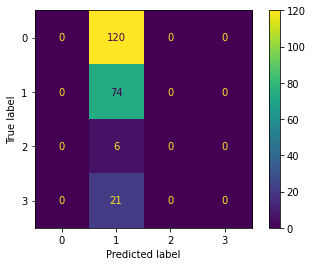

In [6]:
validation_set = IsingData(experiments, 'validation')
model_path = 'af_ising/vit_models/run_0/vit_checkpoint_1_run_0.pth'


trainer.evaluate(model_path, validation_set)

As expected, the performance was garbage. 

One interesting note is everytime I tested validation on one trained epoch, the `vit` always predicted nearly every or all labels to one class. Which class varies every run. Let it train for longer and good chance you will have a better result.